In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import pickle
from sklearn.linear_model import Lasso, LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import ElasticNet
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel
from sklearn.datasets import make_regression

In [2]:
rank_df = pd.read_csv('../input/sample-data/rangering.csv')
user_df = pd.read_csv('../input/sample-data/bruker.csv')
movie_df = pd.read_csv('../input/sample-data/film.csv')
userrank_df = rank_df.merge(user_df,left_on = 'BrukerID', right_on = 'BrukerID')
final_df = userrank_df.merge(movie_df,left_on = 'FilmID', right_on = 'FilmID')

# Overview and visualization


In [3]:
#Exploring user activity
average_numRating= len(final_df['Rangering'])/len(user_df['BrukerID'])
print('The average number of ratings per user is: ' ,average_numRating)
print('\nThe most common rating is : ', final_df['Rangering'].median())
print('\nThe average rating is: ', final_df['Rangering'].mean())
#With a rating scale of 1-5, our dataset is very skewed towards positive reviews. 

user_activity = final_df['BrukerID'].value_counts()
print('\n most active and inactive users \n' ,user_activity)
#All users have rated at least 10 movies. All users in the dataset have rated a significant number of titles.

The average number of ratings per user is:  28.955

The most common rating is :  4.0

The average rating is:  3.5423933690208944

 most active and inactive users 
 122    138
363    100
51      94
126     86
58      86
      ... 
82      10
25      10
179     10
97      10
321     10
Name: BrukerID, Length: 200, dtype: int64


25    0.355
35    0.250
18    0.160
45    0.100
50    0.065
56    0.045
1     0.025
Name: Alder, dtype: float64

 M    0.74
F    0.26
Name: Kjonn, dtype: float64


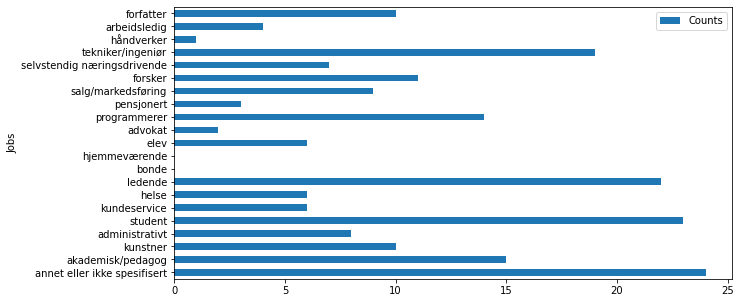

In [4]:
#Exploring user data
age_freq = user_df['Alder'].value_counts(normalize = True)
print(age_freq)
# 76% of the users are in the agerange 18 - 44, and 60% in the range 25-44
gender_freq = user_df['Kjonn'].value_counts(normalize = True)
print('\n',gender_freq)
#74% of the users are Male, meaning the dataset is very skewed towards male preferences in ratings. 
jobs = ["annet eller ikke spesifisert","akademisk/pedagog","kunstner","administrativt","student","kundeservice",
        "helse","ledende","bonde","hjemmeværende","elev","advokat","programmerer","pensjonert","salg/markedsføring","forsker","selvstendig næringsdrivende",
        "tekniker/ingeniør","håndverker","arbeidsledig","forfatter"]
count = user_df['Jobb'].value_counts().sort_index()
jobcount = []
for j in range(len(jobs)):
    if j not in count.index:
        jobcount.append(0)
    else:
        jobcount.append(count[j])
        
df = pd.DataFrame({'Jobs':jobs
                   , 'Counts':jobcount})
ax = df.plot.barh(x='Jobs', y='Counts',figsize = (10,5))
#finding and visualizing occupation distribution among users
#Some occupation labels are not represented in our sample dataset

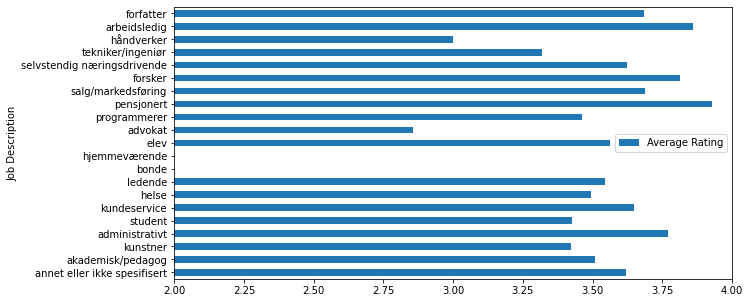

In [5]:
#Exploring ranking habits by occupation
rating_count_by_job = final_df['Jobb'].value_counts().sort_index()
average_rating_by_job = []
for i in range(len(jobs)):
    if i not in rating_count_by_job.index:
        average_rating_by_job.append(0)
    else:
        average_rating_by_job.append(final_df.loc[final_df['Jobb'] == i, 'Rangering'].sum()/rating_count_by_job[i])

df = pd.DataFrame({'Jobs':jobs,'Average Rating':average_rating_by_job})
ax = df.plot.barh(x='Jobs', y='Average Rating',figsize = (10,5),xlabel = "Job Description",ylabel = "Average Rating", xlim = {2,4})
#Advokater, ingeniører og håndverkere rangerer filmer de ser lavere enn gjennomsnittet
#Pensjonister og arbeidsledige rangerer det meste de ser høyere enn de andre gruppene.
#Det er ikke utenkelig at disse tallene er sterkt påvirket av at det er få håndverkere, advokater og pensjonister i datasettet våres

In [6]:
#Exploring movie popularity
pop = rank_df['FilmID'].value_counts()
least = (pop <= 1).where(lambda x : x == True).dropna()
print(int((len(least)/len(movie_df.FilmID.values))*100), '% of the movies have only 1 registered rating')
leastTwo = (pop <= 2).where(lambda x : x == True).dropna()
print(int((len(leastTwo)/len(movie_df.FilmID.values))*100), '% of the movies have 2 or less registered ratings')
leastFive = (pop <= 5).where(lambda x : x == True).dropna()
print(int((len(leastFive)/len(movie_df.FilmID.values))*100), '% of the movies have 5 or less registered ratings')

10 % of the movies have only 1 registered rating
17 % of the movies have 2 or less registered ratings
32 % of the movies have 5 or less registered ratings


In [7]:
#Making the 'Kjonn' column numeric because i want to use it as a parameter in my models
final_df['Kjonn'].replace(['M','F'],[0,1],inplace = True)

In [8]:
#Generating new datasets where i filter out movies based on how many ratings they have.
#I want to check if this matters when prediction ratings later on
rating_threshold = [0,1,2,5]
datasets = []
popularity = rank_df['FilmID'].value_counts()
for threshold in rating_threshold:
    datasets.append(final_df[~final_df.FilmID.isin
                             ((popularity <= threshold).where(lambda x : x == True).dropna().index)])


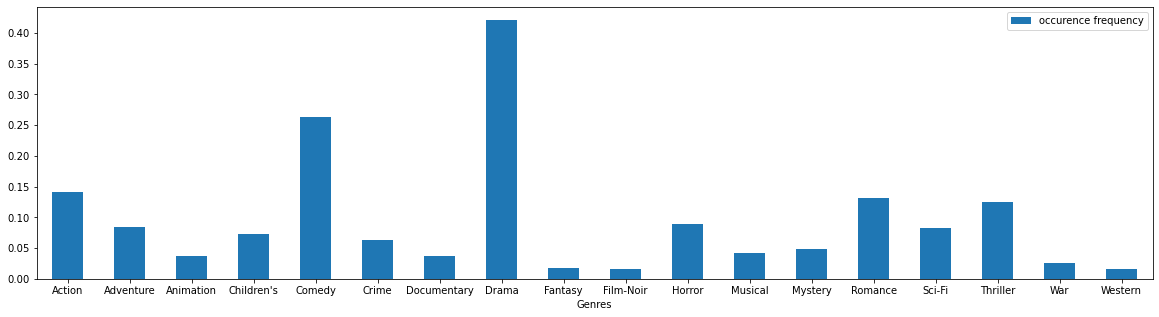

In [9]:
#Exploring genre popularity and correlation with other genres
genres = ['Action', 'Adventure', 'Animation',"Children's",'Comedy','Crime','Documentary','Drama','Fantasy','Film-Noir','Horror','Musical','Mystery','Romance','Sci-Fi','Thriller','War','Western']
genre_distribution = []
for gen in genres:
    genre_distribution.append(movie_df[gen].value_counts(normalize = True)[1])
    
df = pd.DataFrame({'Genres':genres
                   , 'occurence frequency':genre_distribution})
ax = df.plot.bar(x='Genres', y='occurence frequency', rot=0,figsize = (20,5))
#Drama and Comedy are by far the most frequent genres,with Drama occuring in over 40% of all movies in the dataset.
#Fantasy, Film-Noir and Western are the least frequent 

In [10]:
movie_df.drop(columns = ['FilmID','Tittel']).corr().style.background_gradient(cmap='coolwarm')
#The only strong correlation is between the animation and children's genre
#There is some correlations between combinations such as action-adventure, fantasy-adventure, animation-musical, film-noir-crime, musical-animation, musical-children's etc.
#Some genres such as Documentary, War and Western has no correlation to other genres and is mostly independent.

,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
Action,1.000000,0.271559,-0.079013,-0.091585,-0.097822,0.134207,-0.079013,-0.158404,0.031453,-0.052131,-0.065919,-0.085614,0.016177,-0.037958,0.151286,0.196490,0.005726,0.039843
Adventure,0.271559,1.000000,0.095659,0.193759,-0.083278,0.010905,-0.059277,-0.186458,0.229814,-0.039110,-0.069838,0.007719,-0.035125,0.031641,0.145068,0.015965,-0.050113,-0.039110
Animation,-0.079013,0.095659,1.000000,0.610483,-0.067145,-0.050318,-0.037815,-0.165837,0.054288,-0.024949,-0.060807,0.280316,0.006307,-0.043734,-0.019342,-0.073669,-0.031969,-0.024949
Children's,-0.091585,0.193759,0.610483,1.000000,-0.026063,-0.072545,-0.054519,-0.175999,0.252961,-0.035970,-0.060327,0.211135,-0.063354,-0.063053,0.000343,-0.106212,-0.046091,0.025729
Comedy,-0.097822,-0.083278,-0.067145,-0.026063,1.000000,-0.059859,-0.116213,-0.248943,-0.047036,-0.076674,-0.122315,0.010793,-0.049516,0.148162,-0.129799,-0.170895,-0.069529,-0.040254
Crime,0.134207,0.010905,-0.050318,-0.072545,-0.059859,1.000000,-0.050318,-0.017796,-0.035249,0.231318,-0.080912,-0.054522,-0.019648,-0.026642,-0.047589,0.103535,-0.042539,-0.033198
Documentary,-0.079013,-0.059277,-0.037815,-0.054519,-0.116213,-0.050318,1.000000,-0.165837,-0.026490,-0.024949,-0.060807,0.066123,-0.043943,-0.075694,-0.058503,-0.073669,-0.031969,-0.024949
Drama,-0.158404,-0.186458,-0.165837,-0.175999,-0.248943,-0.017796,-0.165837,1.000000,-0.085515,-0.076932,-0.252273,-0.159369,-0.078289,0.031919,-0.197114,-0.174564,0.090321,-0.076932
Fantasy,0.031453,0.229814,0.054288,0.252961,-0.047036,-0.035249,-0.026490,-0.085515,1.000000,-0.017477,-0.042596,0.046320,-0.030783,-0.008248,0.123612,-0.051606,-0.022395,-0.017477
Film-Noir,-0.052131,-0.039110,-0.024949,-0.035970,-0.076674,0.231318,-0.024949,-0.076932,-0.017477,1.000000,-0.040119,-0.027034,0.194792,-0.049941,0.019535,0.096622,-0.021092,-0.016461


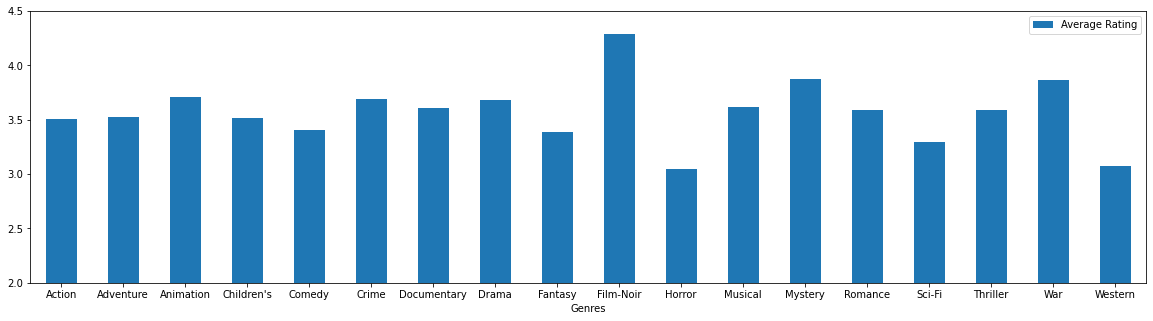

In [11]:
genre_ratings = []
for gen in genres:
    genre_ratings.append(final_df.loc[final_df[gen] == 1, 'Rangering'].sum()/final_df[gen].value_counts()[1])
df = pd.DataFrame({'Genres':genres, 'Average Rating':genre_ratings})
ax = df.plot.bar(x='Genres', y='Average Rating', rot=0,figsize = (20,5), ylim = {2,4.5})
#Film-Noir movies are consistently rated very highly while Horror and western-movies tend to be rated lower than average
#Most genres hover around the 3.5 rating, which is the mean rating we found earlier.

# Basemodel
For my basemodel i decided to predict the mean rating of the movie for every user.    
I split the data 70-15-15, then i calculate the mean rating of every movie from the training dataset, which i will use as predictions on validation and testdata.  
When a movie with no seen ratings appears, I fill with the mean rating of the entire training dataset.

In [12]:
X = rank_df.FilmID.values
y = rank_df.Rangering.values
X_train, X_valtest, y_train, y_valtest = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_valtest, y_valtest, test_size=0.5, random_state=42)

In [13]:
meanmodel =pd.DataFrame(X_train)
meanmodel['Rangering'] = y_train
meanmodel.columns = ['FilmID','Rangering']
fill = meanmodel.Rangering.mean()
for fid in meanmodel.FilmID.unique():
    meanmodel.loc[meanmodel.FilmID == fid,'Rangering'] = meanmodel[meanmodel.FilmID == fid].Rangering.mean()
meanmodel

,FilmID,Rangering
0,48,3.785714
1,396,4.323529
2,140,3.657895
3,150,4.266667
4,352,3.722222
...,...,...
4048,3,3.391304
4049,149,3.750000
4050,242,4.000000
4051,125,4.312500


In [14]:
val = pd.DataFrame(X_val)
val.columns = ['FilmID']
val['actual'] = y_val
val['prediction'] = y_val
for fid in val.FilmID.unique():
    #I use the mean of the mean model here for simplicity. If the movieID is unseen the 'predicted' value is nan so that i can fill it later.
    val.loc[val.FilmID == fid, 'prediction'] = meanmodel[meanmodel.FilmID == fid].Rangering.mean()
val.prediction.fillna(fill,inplace = True)
print('base model validation rmse: ', np.around(np.square(mean_squared_error(val['actual'],val['prediction'])),4))

base model validation rmse:  1.1679


In [15]:
gen = pd.DataFrame(X_test)
gen.columns = ['FilmID']
gen['actual'] = y_test
gen['prediction'] = y_test
for fid in gen.FilmID.unique():
    gen.loc[gen.FilmID == fid, 'prediction'] = meanmodel[meanmodel.FilmID == fid].Rangering.mean()
gen.prediction.fillna(fill,inplace = True)
print('base model estimated generalisation error: ', np.around(np.square(mean_squared_error(gen['actual'],gen['prediction'])),4))

base model estimated generalisation error:  1.2225


# Content based Filtering model selection
For my content based filtering model i want to check performance on all the regression models that i know of.  
I have decided to use movie-categories to predict movie ratings. Since i make a model for each user, i dont think there is any point in including user labels such as age, job, etc. as those would be constants.  
Models are evaluated based on their root mean squared error on the validation dataset, i split the data for every user 70-15-15.  
For every user i create a model and store the validation root mean squared error, then i evaluate the total performance of the model on the mean of all the validation scores.

In [16]:
# Epsilon-Support Vector Regression with a few different epsilon values
epsilon = np.arange(0.1,1,0.1)
for e in epsilon:
    user_svr_val = []
    for uid in final_df.BrukerID.unique():
        xx = final_df[final_df.BrukerID == uid].drop(columns = ['BrukerID','Tittel','Rangering','FilmID','Postkode','Tidstempel','Alder','Kjonn','Jobb']).values
        yy = final_df[final_df.BrukerID == uid].Rangering.values
    
        X_train, X_valtest, y_train, y_valtest = train_test_split(xx, yy,test_size=0.3, random_state=42)
        X_val, X_test, y_val, y_test = train_test_split(X_valtest, y_valtest,test_size=0.5, random_state=42)
        svr = make_pipeline(StandardScaler(), SVR(C=1.0, epsilon=e))
        svr.fit(X_train,y_train)
        user_svr_val.append(np.sqrt(mean_squared_error(y_val,np.clip(svr.predict(X_val),1,5))))
    print('epsilon: ', np.around(e,2), 'validation rmse: ', np.around(pd.DataFrame(user_svr_val).mean()[0],4))

epsilon:  0.1 validation rmse:  0.9654
epsilon:  0.2 validation rmse:  0.9608
epsilon:  0.3 validation rmse:  0.9593
epsilon:  0.4 validation rmse:  0.9578
epsilon:  0.5 validation rmse:  0.9595
epsilon:  0.6 validation rmse:  0.9566
epsilon:  0.7 validation rmse:  0.9576
epsilon:  0.8 validation rmse:  0.9593
epsilon:  0.9 validation rmse:  0.9622


In [17]:
logisticRegression = []
linearRegression = []
polynomialRegression = []
elasticNet = []
gaussianRegression = []
for uid in final_df.BrukerID.unique():
    
    xx = final_df[final_df.BrukerID == uid].drop(columns = ['BrukerID','Tittel','Rangering','FilmID','Postkode','Tidstempel','Alder','Kjonn','Jobb']).values
    yy = final_df[final_df.BrukerID == uid].Rangering.values
    
    X_train, X_valtest, y_train, y_valtest = train_test_split(xx, yy,test_size=0.3, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_valtest, y_valtest,test_size=0.5, random_state=42)
        
    lg = LogisticRegression(random_state = 42,solver = 'liblinear')
    lg.fit(X_train,y_train)
    logisticRegression.append(np.sqrt(mean_squared_error(y_val,np.clip(lg.predict(X_val),1,5))))
        
    lr = LinearRegression()
    lr.fit(X_train,y_train)
    linearRegression.append(np.sqrt(mean_squared_error(y_val,np.clip(lr.predict(X_val),1,5))))
        
        
    pf = PolynomialFeatures(degree=2)
    X_train_pf = pf.fit_transform(X_train)
    X_val_pf = pf.transform(X_val)
    lr = LinearRegression()
    lr.fit(X_train_pf,y_train)
    polynomialRegression.append(np.sqrt(mean_squared_error(y_val,np.clip(lr.predict(X_val_pf),1,5))))
    
    enet = ElasticNet(random_state = 42)
    enet.fit(X_train,y_train)
    elasticNet.append(np.sqrt(mean_squared_error(y_val,np.clip(enet.predict(X_val),1,5))))
    
    kernel = DotProduct() + WhiteKernel()
    gpr = GaussianProcessRegressor(kernel=kernel,random_state = 42).fit(X_train,y_train)
    gaussianRegression.append(np.sqrt(mean_squared_error(y_val,np.clip(gpr.predict(X_val),1,5))))

print('Logistic Regression validation rmse: ', np.around(pd.DataFrame(logisticRegression).mean()[0],4))
print('Linear Regression validation rmse: ', np.around(pd.DataFrame(linearRegression).mean()[0],4))
print('Polynomial Regression validation rmse: ', np.around(pd.DataFrame(polynomialRegression).mean()[0],4))
print('Elastic net validation rmse:' , np.around(pd.DataFrame(elasticNet).mean()[0],4))
print('Guassian Regression validation rmse:' , np.around(pd.DataFrame(gaussianRegression).mean()[0],4))

Logistic Regression validation rmse:  1.0923
Linear Regression validation rmse:  1.2168
Polynomial Regression validation rmse:  1.4571
Elastic net validation rmse: 0.9399
Guassian Regression validation rmse: 1.0435


In [18]:
# Lasso Regression with a few different alpha values
alpha = np.arange(0.05,1,0.1)
for a in alpha:
    user_lasso_val= []
    for uid in final_df.BrukerID.unique():
        xx = final_df[final_df.BrukerID == uid].drop(columns = ['BrukerID','Tittel','Rangering','FilmID','Postkode','Tidstempel','Alder','Kjonn','Jobb']).values
        yy = final_df[final_df.BrukerID == uid].Rangering.values
    
        X_train, X_valtest, y_train, y_valtest = train_test_split(xx, yy,test_size=0.3, random_state=42)
        X_val, X_test, y_val, y_test = train_test_split(X_valtest, y_valtest,test_size=0.5, random_state=42)
        lasso = Lasso(alpha = a, random_state = 42)
        lasso.fit(X_train,y_train)
        user_lasso_val.append(np.sqrt(mean_squared_error(y_val,np.clip(lasso.predict(X_val),1,5))))
    print('alpha: ', np.around(a,2), 'validation rmse: ', np.around(pd.DataFrame(user_lasso_val).mean()[0],4))

alpha:  0.05 validation rmse:  0.9824
alpha:  0.15 validation rmse:  0.9435
alpha:  0.25 validation rmse:  0.9408
alpha:  0.35 validation rmse:  0.9408
alpha:  0.45 validation rmse:  0.939
alpha:  0.55 validation rmse:  0.9397
alpha:  0.65 validation rmse:  0.94
alpha:  0.75 validation rmse:  0.9405
alpha:  0.85 validation rmse:  0.9408
alpha:  0.95 validation rmse:  0.9408


In [19]:
#Random Forest Regressor with depth 1-3
depth = np.arange(1,4,1)
for d in depth:
    user_forest_val= []
    for uid in final_df.BrukerID.unique():
        xx = final_df[final_df.BrukerID == uid].drop(columns = ['BrukerID','Tittel','Rangering','FilmID','Postkode','Tidstempel','Alder','Kjonn','Jobb']).values
        yy = final_df[final_df.BrukerID == uid].Rangering.values
    
        X_train, X_valtest, y_train, y_valtest = train_test_split(xx, yy,test_size=0.3, random_state=42)
        X_val, X_test, y_val, y_test = train_test_split(X_valtest, y_valtest,test_size=0.5, random_state=42)
        regr = RandomForestRegressor(n_estimators = 100,max_depth=d, random_state=42)
        regr.fit(X_train, y_train)
        user_forest_val.append(np.sqrt(mean_squared_error(y_val,np.clip(regr.predict(X_val),1,5))))
    print('depth: ', d, 'validation rmse: ', np.around(pd.DataFrame(user_forest_val).mean()[0],4))

depth:  1 validation rmse:  0.9578
depth:  2 validation rmse:  0.972
depth:  3 validation rmse:  0.9854


We want a model that outperforms our basemodel, which has a validation rmse of 1.16.  
Most of the models tested here perform better than our basemodel on the validation dataset.  
The best performing methods are the Elastic Net and the Lasso. However, they predict the same rating for every movie, much like our basemode.
This behaviour is unwanted since later on i want to recommend the highest rated unseen movies. 
The best models with desired behaviour are the Epsilon-Support Vector Regression and the Random Forest Regressor.  
The first thing i want to do is check the expected generalisation rmse, then i want to retest the models on the rating thresholds i outlined earlier.  

In [20]:
svr_gen = []
rfg_gen = []
for uid in final_df.BrukerID.unique():
    
    xx = final_df[final_df.BrukerID == uid].drop(columns = ['BrukerID','Tittel','Rangering','FilmID','Postkode','Tidstempel','Alder','Kjonn','Jobb']).values
    yy = final_df[final_df.BrukerID == uid].Rangering.values
    
    X_train, X_valtest, y_train, y_valtest = train_test_split(xx, yy,test_size=0.3, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_valtest, y_valtest,test_size=0.5, random_state=42)
    
    svr = make_pipeline(StandardScaler(), SVR(C=1.0, epsilon=0.6))
    svr.fit(X_train,y_train)
    svr_gen.append(np.sqrt(mean_squared_error(y_test,np.clip(svr.predict(X_test),1,5))))
    
    regr = RandomForestRegressor(n_estimators = 100,max_depth=1, random_state=42)
    regr.fit(X_train, y_train)
    rfg_gen.append(np.sqrt(mean_squared_error(y_test,np.clip(regr.predict(X_test),1,5))))
print('Epsilon-Support Vector Regression estimated generalisation error : ', np.around(pd.DataFrame(svr_gen).mean()[0],4))
print('Random Forest Regressor estimated generalisation error: ', np.around(pd.DataFrame(rfg_gen).mean()[0],4))

Epsilon-Support Vector Regression estimated generalisation error :  0.9723
Random Forest Regressor estimated generalisation error:  0.9742


The best models generalise fairly well on the testdata and outperformns our basemodel.  
Now i want to check what happens if i remove movies with very few ratings from our dataset.  
i only test this on the Epsilon-Support Vector Regression since the Random Forest Regression is very slow.


In [21]:
threshold = 0
svr_val = []
svr_gen = []
for data in datasets:
    for uid in final_df.BrukerID.unique():
        xx = data[data.BrukerID == uid].drop(columns = ['BrukerID','Tittel','Rangering','FilmID','Postkode','Tidstempel','Alder','Kjonn','Jobb']).values
        yy = data[data.BrukerID == uid].Rangering.values
    
        X_train, X_valtest, y_train, y_valtest = train_test_split(xx, yy,test_size=0.3, random_state=42)
        X_val, X_test, y_val, y_test = train_test_split(X_valtest, y_valtest,test_size=0.5, random_state=42)
    
        svr = make_pipeline(StandardScaler(), SVR(C=1.0, epsilon=0.6))
        svr.fit(X_train,y_train)
        svr_val.append(np.sqrt(mean_squared_error(y_val,np.clip(svr.predict(X_val),1,5))))
        svr_gen.append(np.sqrt(mean_squared_error(y_test,np.clip(svr.predict(X_test),1,5))))
        
    print('\n')
    print('Rating Threshold' ,rating_threshold[threshold])
    print('Epsilon-Support Vector Regression validation rmse: ',np.around(pd.DataFrame(svr_val).mean()[0],4), ' generalisation error: ', np.around(pd.DataFrame(svr_gen).mean()[0],4))
    threshold = threshold + 1



Rating Threshold 0
Epsilon-Support Vector Regression validation rmse:  0.9566  generalisation error:  0.9723


Rating Threshold 1
Epsilon-Support Vector Regression validation rmse:  0.9582  generalisation error:  0.9698


Rating Threshold 2
Epsilon-Support Vector Regression validation rmse:  0.9545  generalisation error:  0.9706


Rating Threshold 5
Epsilon-Support Vector Regression validation rmse:  0.9507  generalisation error:  0.9653


Removing movies with few ratings does not seem to improve our model in any significant way

# Collaborative Filtering Model selection 
Note: The standard cbf model outlined in the lecture is very slow and I have replaced it with a lazy implementation which does not check if the correlated users has rated the movie.      
Here is the link to an external notebook where i explored the difference between the standard implementation and my lazy implementation: https://www.kaggle.com/oscarsommervold/collaborative-filtering-model  
The performance between the two models are nearly identical.

In [22]:
rank_df.drop(columns = 'Tidstempel', inplace = True)

In [23]:
# split data 70-15-15
X = rank_df.drop(columns = 'Rangering').values
y = rank_df.Rangering.values
X_train, X_valtest, y_train, y_valtest = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_valtest, y_valtest,test_size=0.5, random_state=42)

matrix = pd.DataFrame(X_train)
matrix.columns = ['BrukerID','FilmID']
matrix['Rangering'] = y_train
    
table = pd.pivot_table(matrix,values = 'Rangering',index = 'FilmID',columns = 'BrukerID')
#user 206 is missing, so for simplicity i add a dummy user which will later be removed
table[206] = pd.Series(0.0).repeat(len(table.index)).values
table= table.reindex(sorted(table.columns), axis=1)

#adding all movies missing from our trainingdata
missing_movies = movie_df.loc[~movie_df.FilmID.isin(table.index)].FilmID.values
for movieid in missing_movies:
    table.loc[movieid] = [np.nan]*len(table.columns)

#saving current tablestate, used to calculate mean rating for each user
train_data = table.copy()

#subtract all ratings by user mean rating, do this for all users
for col in table.columns:
    table[col]-= table[col].mean()

table.fillna(0,inplace = True)

#generate correlation matrix
matrix_cor = pd.DataFrame(np.corrcoef(table.values,rowvar = False), index =table.columns, columns = table.columns )

#for each user, take the 50 most correlated users and generate a matrix of their ratings.
#Calculate the mean for each row (movie) in this generated matrix, this is our prediction vector.
#If none of the correlated users rated the movie, the predicted rating will be the mean rating of the user.
for vector in table.columns:
    table[vector] = table.loc[:,matrix_cor[vector].sort_values(kind = "quicksort",ascending = False)[1:51].index].replace(0,np.nan).mean(numeric_only = True,axis = 1)

#snapshot of table. To be used for the combined model selection.
tablesnapshot = table.copy()
table.fillna(0,inplace = True)

# add back on the mean rating for each user
for vector in table.columns:
    table[vector]+=train_data[vector].mean()
    table[vector] = np.clip(table[vector],1,5)

#drop dummy user
table.drop(columns = 206, inplace = True)


X_val_predictions = []
for brukerid,filmid in X_val:
    X_val_predictions.append(table[brukerid][filmid])

X_test_predictions = []
for brukerid,filmid in X_test:
    X_test_predictions.append(table[brukerid][filmid])

table

/opt/conda/lib/python3.7/site-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/opt/conda/lib/python3.7/site-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


BrukerID,0,4,6,8,9,11,12,16,17,18,...,365,367,369,374,375,377,378,379,380,381
FilmID,,,,,,,,,,,,,,,,,,,,,
0,2.797651,4.295179,3.166667,3.670122,2.846413,3.978818,3.221786,3.642956,3.045122,2.944601,...,4.025150,3.461595,4.113634,4.183864,3.349780,3.125354,2.755273,2.661810,2.519812,4.427269
3,3.578645,3.432491,2.783267,3.472629,3.222435,2.635984,3.381442,4.300279,2.896336,2.585135,...,3.867126,3.352035,3.947460,4.069830,3.118613,2.902067,2.673802,2.508649,2.435463,4.315354
5,3.509308,2.713950,3.516733,4.187069,2.296149,2.883229,1.838950,3.888966,3.802067,2.497544,...,3.697677,3.256108,3.818570,3.889038,3.019899,2.767764,2.531758,2.382054,2.257293,4.116700
6,1.225589,2.935185,1.950758,4.125000,1.868056,2.570426,2.060185,2.824425,1.801136,1.920139,...,2.909149,2.330503,2.984701,3.046198,2.204618,1.996860,1.626280,1.549992,1.412418,3.308797
7,3.407407,3.873950,2.577381,4.125000,2.435652,3.237586,3.125000,3.472689,3.315476,3.007703,...,3.821619,3.366173,3.951000,4.058551,3.163955,2.925922,2.634847,2.508061,2.364660,4.240977
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
474,3.407407,4.000000,3.166667,4.125000,2.962963,3.363636,3.125000,4.000000,3.500000,3.000000,...,4.080000,3.583333,4.200000,4.285714,3.400000,3.157895,2.870968,2.740741,2.615385,4.500000
481,3.407407,4.000000,3.166667,4.125000,2.962963,3.363636,3.125000,4.000000,3.500000,3.000000,...,4.080000,3.583333,4.200000,4.285714,3.400000,3.157895,2.870968,2.740741,2.615385,4.500000
490,3.407407,4.000000,3.166667,4.125000,2.962963,3.363636,3.125000,4.000000,3.500000,3.000000,...,4.080000,3.583333,4.200000,4.285714,3.400000,3.157895,2.870968,2.740741,2.615385,4.500000


In [24]:
print(' \n Lazy collaborative filtering model: \n validation rmse :' ,
        np.around(np.sqrt(mean_squared_error(y_val,X_val_predictions)),4) ,
    ' \n generalization rmse :  ',np.around(np.sqrt(mean_squared_error(y_test,X_test_predictions)),4))

 
 Lazy collaborative filtering model: 
 validation rmse : 1.0163  
 generalization rmse :   1.0083


# Mixed model
Generate a table for a Content Based Filtering Model using Epsilon-Support Vector Regression.  
Compare with the table generated in the Collaborative Filtering Model.  
Generate a new column for each user, where the new column is the mean between the two models.  
For my mixed model i want to also try the Logistic Regression model, since the predictions are integers.  
I might also try to impute values from the Logistic Regression model if i can make it work.  
The overall model performances will be evaluated on the same validation set as Collaborative model

In [25]:
user_df['Kjonn'].replace(['M','F'],[0,1],inplace = True)

In [26]:
svr_model_predictions = []
lg_model_predictions= []
for uid in final_df.BrukerID.unique():
    
    X = final_df.loc[final_df['BrukerID'] == uid].drop(columns = ['BrukerID','Tittel','Rangering','FilmID','Postkode','Tidstempel','Alder','Kjonn','Jobb']).values
    y = final_df.loc[final_df['BrukerID'] == uid].Rangering.values
    
    svr = make_pipeline(StandardScaler(), SVR(C=1.0, epsilon=0.6))
    #fit the model with data
    svr.fit(X,y)
    
    #predict rating for all movies
    svr_model_predictions.append(pd.DataFrame(np.clip(svr.predict(movie_df.drop(columns = ['Tittel','FilmID'])),1,5)))
    
    #Also doing this for a Logistic Regression Model since the predictions are integers
    lg = LogisticRegression(random_state = 42,solver = 'liblinear')
    lg.fit(X,y)
    lg_model_predictions.append(pd.DataFrame(np.clip(lg.predict(movie_df.drop(columns = ['Tittel','FilmID'])),1,5)))

In [27]:
svr_matrix = movie_df[['FilmID','Tittel']]
for (i,uid) in enumerate(user_df.BrukerID):
    svr_matrix[uid] = svr_model_predictions[i]
svr_matrix.set_index('FilmID',inplace = True)
svr_matrix

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,Tittel,0,4,6,8,9,11,12,16,17,...,365,367,369,374,375,377,378,379,380,381
FilmID,,,,,,,,,,,,,,,,,,,,,
0,Autumn in New York (2000),3.600078,3.631889,3.518056,3.176280,3.692152,4.477276,3.4,3.480934,2.600058,...,3.399905,3.763346,3.399987,3.611756,2.373685,4.400093,3.621348,2.355698,3.6,3.612766
1,"Vie est belle, La (Life is Rosey) (1987)",3.465270,3.777959,3.136368,3.141115,3.423456,4.004006,3.4,3.542289,3.431750,...,3.298853,3.925989,3.118795,3.742044,1.946385,3.878280,3.657478,2.355698,3.6,3.794502
2,Defying Gravity (1997),3.662182,3.599991,3.600368,3.289755,3.271304,4.399844,3.4,3.638554,3.399935,...,3.285217,4.281800,3.248159,3.599666,2.600149,3.600573,3.600351,2.371801,3.6,3.600039
3,Ruthless People (1986),3.324326,3.976634,2.881098,2.781891,3.581963,3.611790,3.4,3.585097,3.400226,...,3.223652,3.906591,3.007464,3.864179,2.207546,3.881482,3.599722,1.933415,3.6,4.399961
4,Portraits Chinois (1996),3.662182,3.599991,3.600368,3.289755,3.271304,4.399844,3.4,3.638554,3.399935,...,3.285217,4.281800,3.248159,3.599666,2.600149,3.600573,3.600351,2.371801,3.6,3.600039
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
496,Lethal Weapon 4 (1998),3.624720,2.916280,3.287918,3.137158,3.816635,4.114088,3.4,3.449576,3.399901,...,3.400215,3.843894,3.399946,3.586993,2.218346,3.896864,3.693978,2.332319,3.6,3.718096
497,Only You (1994),3.165274,4.028666,3.399902,3.157059,3.918926,3.950746,3.4,3.469868,3.345026,...,3.314096,3.821956,3.399967,3.855121,2.190427,3.920630,3.620833,1.959030,3.6,4.343175
498,You Can't Take It With You (1938),3.324326,3.976634,2.881098,2.781891,3.581963,3.611790,3.4,3.585097,3.400226,...,3.223652,3.906591,3.007464,3.864179,2.207546,3.881482,3.599722,1.933415,3.6,4.399961


In [28]:
combi = pd.DataFrame(movie_df.FilmID)
combi.set_index('FilmID',inplace = True)
for uid in user_df.BrukerID.unique():
    combi[uid] = (table[uid] + svr_matrix[uid])/2

X_val_predictions = []
for brukerid,filmid in X_val:
    X_val_predictions.append(combi[brukerid][filmid])

X_test_predictions = []
for brukerid,filmid in X_test:
    X_test_predictions.append(combi[brukerid][filmid])
    
print(' \n combined model with Epsilon-Support Vector Regression : \n validation rmse :' ,
        np.around(np.sqrt(mean_squared_error(y_val,X_val_predictions)),4) ,
    ' \n generalization rmse :  ',np.around(np.sqrt(mean_squared_error(y_test,X_test_predictions)),4))

 
 combined model with Epsilon-Support Vector Regression : 
 validation rmse : 1.0159  
 generalization rmse :   1.021


In [29]:
lg_matrix = movie_df[['FilmID','Tittel']]
for (i,uid) in enumerate(user_df.BrukerID):
    lg_matrix[uid] = lg_model_predictions[i]
lg_matrix.set_index('FilmID',inplace = True)
lg_matrix

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,Tittel,0,4,6,8,9,11,12,16,17,...,365,367,369,374,375,377,378,379,380,381
FilmID,,,,,,,,,,,,,,,,,,,,,
0,Autumn in New York (2000),3,4,3,4,4,4,4,5,2,...,4,4,4,4,2,5,4,3,4,3
1,"Vie est belle, La (Life is Rosey) (1987)",3,5,3,4,4,4,4,5,2,...,3,4,3,4,2,4,4,3,3,5
2,Defying Gravity (1997),4,4,3,4,4,4,4,5,3,...,4,4,3,4,2,5,4,3,4,3
3,Ruthless People (1986),3,5,2,2,4,3,4,5,4,...,3,4,3,5,2,4,3,1,3,5
4,Portraits Chinois (1996),4,4,3,4,4,4,4,5,3,...,4,4,3,4,2,5,4,3,4,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
496,Lethal Weapon 4 (1998),4,2,3,4,4,4,4,5,4,...,4,4,4,4,1,4,3,3,3,3
497,Only You (1994),3,4,3,4,4,5,4,5,2,...,3,4,4,5,1,5,3,1,3,5
498,You Can't Take It With You (1938),3,5,2,2,4,3,4,5,4,...,3,4,3,5,2,4,3,1,3,5


In [30]:
combi = pd.DataFrame(movie_df.FilmID)
combi.set_index('FilmID',inplace = True)
for uid in user_df.BrukerID.unique():
    combi[uid] = (table[uid] + lg_matrix[uid])/2

X_val_predictions = []
for brukerid,filmid in X_val:
    X_val_predictions.append(combi[brukerid][filmid])

X_test_predictions = []
for brukerid,filmid in X_test:
    X_test_predictions.append(combi[brukerid][filmid])
    
print(' \n combined model with Logistic Regression: \n validation rmse :' ,
        np.around(np.sqrt(mean_squared_error(y_val,X_val_predictions)),4) ,
    ' \n generalization rmse :  ',np.around(np.sqrt(mean_squared_error(y_test,X_test_predictions)),4))

 
 combined model with Logistic Regression: 
 validation rmse : 1.0838  
 generalization rmse :   1.0949


In [31]:
for col in lg_matrix.drop(columns = 'Tittel').columns:
    lg_matrix[col]-= lg_matrix[col].mean()
    
t = tablesnapshot.fillna(lg_matrix.drop(columns = 'Tittel'))

for vector in t.columns:
    t[vector]+=train_data[vector].mean()
    t[vector] = np.clip(t[vector],1,5)

    
X_val_predictions = []
for brukerid,filmid in X_val:
    X_val_predictions.append(t[brukerid][filmid])

X_test_predictions = []
for brukerid,filmid in X_test:
    X_test_predictions.append(t[brukerid][filmid])
    
print(' \n Collaborative Filtering with Logistic Regression imputation : \n validation rmse :' ,
        np.around(np.sqrt(mean_squared_error(y_val,X_val_predictions)),4) ,
    ' \n generalization rmse :  ',np.around(np.sqrt(mean_squared_error(y_test,X_test_predictions)),4))

 
 Collaborative Filtering with Logistic Regression imputation : 
 validation rmse : 1.0181  
 generalization rmse :   1.0104


Overall the Collaborative Filtering Models provided the best validation rmse.  
My combined models performed a little worse overall than the Collaborative Filtering model and the Content Based Filtering Model.  
My initial thought that the Logistic Regression would perform better in a combined model did not seem to be correct, as it performed worse than the Epsilon-Support Vector Regression.
Using Logistic Regression imputation yielded slightly better validation rmse than the combined approach with Logistic Regression.  
When i am going to recommend movies i might try Logistic Regression again to look at predicted five star ratings, but until then i will use the Epsilon-Support Vector Regression, as its the best model.  

Saving Epsilon-Support Vector Regression model to disk

In [32]:
user_models = {}
for uid in final_df.BrukerID.unique():
    xx = final_df[final_df.BrukerID == uid].drop(columns = ['BrukerID','Tittel','Rangering','FilmID','Postkode','Tidstempel','Alder','Kjonn','Jobb']).values
    yy = final_df[final_df.BrukerID == uid].Rangering.values
    
    X_train, X_valtest, y_train, y_valtest = train_test_split(xx, yy,test_size=0.3, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_valtest, y_valtest,test_size=0.5, random_state=42)
    svr = make_pipeline(StandardScaler(), SVR(C=1.0, epsilon=0.6))
    
    #fitting the saved models with both train and validation data
    xtrain = np.concatenate((X_train,X_val),axis = 0)
    ytrain = np.concatenate((y_train,y_val),axis = 0)
    svr.fit(xtrain,ytrain)
    user_models[uid] = svr
pickle.dump(user_models,open('model.pkl','wb'))